In [ ]:


#https://youtu.be/YV9D3TWY5Zo
#https://youtu.be/8wrLjnQ7EWQ

"""
VAEs can be used for generative purposes. 
This code demonstrates VAE using MNIST dataset.
Just like regular autoencoder VAE returns an array (image) of same domensions
as input but we can introduce variation by tweaking the latent vector.
"""

import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
#from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
from keras.datasets.cifar10 import load_data
from keras.layers import Input

import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import matplotlib.pyplot as plt

latent_dim = 2 # Number of latent dim parameters
intermediate_dim = 128
filters = 32
batch_size = 256
img_rows, img_cols, img_chns = 32, 32, 3
epsilon_std = 1.0
num_conv = 3
epochs = 50

if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else: # the one used by tensorflow
    original_img_size = (img_rows, img_cols, img_chns)

# # Load MNIST
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# #Normalize and reshape ============

# #Norm.
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train = x_train / 255
# x_test = x_test / 255

# # Reshape 
# img_width  = x_train.shape[1]
# img_height = x_train.shape[2]
# num_channels = 1 #MNIST --> grey scale so 1 channel
# x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
# x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
num_channels = 3
input_shape = (img_rows, img_cols, num_channels)
# # ========================
# #View a few images
# plt.figure(1)
# plt.subplot(221)
# plt.imshow(x_train[42][:,:,0])

# plt.subplot(222)
# plt.imshow(x_train[420][:,:,0])

# plt.subplot(223)
# plt.imshow(x_train[4200][:,:,0])

# plt.subplot(224)
# plt.imshow(x_train[42000][:,:,0])
# plt.show()

import keras
print(keras.__version__)

# (x_train, y_train), (x_test, y_test) = load_data()

# # plot 25 images
# for i in range(25):
#   plt.subplot(5, 5, 1 + i)
#   plt.axis('off')
#   plt.imshow(x_train[i])
# plt.show()

# # Normalize and reshape ============

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train = x_train / 255
# x_test = x_test / 255

# # Reshape
# img_width = x_train.shape[1]
# img_height = x_train.shape[2]
# num_channels = 3

# x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
# x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
# input_shape = (img_height, img_width, num_channels)

# #View a few images
# plt.figure(1)
# plt.subplot(221)
# plt.imshow(x_train[42][:,:,0])

# plt.subplot(222)
# plt.imshow(x_train[420][:,:,0])

# plt.subplot(223)
# plt.imshow(x_train[4200][:,:,0])

# plt.subplot(224)
# plt.imshow(x_train[42000][:,:,0])
# plt.show()


(x_train, _), (x_test, y_test) = load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)



2.9.0


In [ ]:
# BUILD THE MODEL

# # ================= #############
# # Encoder
#Let us define 4 conv2D, flatten and then dense
# # ================= ############


x = Input(shape=input_shape, name='encoder_input')
# x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
# x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
# x = Conv2D(64, 3, padding='same', activation='relu')(x)
# x = Conv2D(64, 3, padding='same', activation='relu')(x)
conv_1 = Conv2D(num_channels, kernel_size=(2,2), padding='same', activation='relu')(x)
conv_2 = Conv2D(filters, kernel_size=(2,2), strides=(2,2), padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters, kernel_size=num_conv, strides=1, padding='same', activation='relu')(conv_2)
conv_4 = Conv2D(filters, kernel_size=num_conv, strides=1, padding='same', activation='relu')(conv_3)

# conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
#Flatten
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

# Two outputs, for latent mean and log variance (std. dev.)
#Use these to sample random variables in latent space to which inputs are mapped. 
z_mean = Dense(latent_dim, name='latent_mu')(hidden)   #Mean values of encoded input
z_log_var = Dense(latent_dim, name='latent_sigma')(hidden)  #Std dev. (variance) of encoded input

#REPARAMETERIZATION TRICK
# Define sampling function to sample from the distribution
# Reparameterize sample based on the process defined by Gunderson and Huang
# into the shape of: mu + sigma squared x eps
#This is to allow gradient descent to allow for gradient estimation accurately. 
def sample_z(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                            mean=0., stddev=epsilon_std)
  return z_mean + K.exp(z_log_var) * epsilon

# sample vector from the latent distribution
# z is the labda custom layer we are adding for gradient descent calculations
  # using mu and variance (sigma)
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.
# encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
# print(encoder.summary())

# ================= ###########
# Decoder
#
# ================= #################

# decoder takes the latent vector as input
# decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

# # Need to start with a shape that can be remapped to original image shape as
# #we want our final utput to be same shape original input.
# #So, add dense layer with dimensions that can be reshaped to desired output shape
# x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
# # reshape to the shape of last conv. layer in the encoder, so we can 
# x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
# # upscale (conv2D transpose) back to original shape
# # use Conv2DTranspose to reverse the conv layers defined in the encoder
# x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
# #Can add more conv2DTranspose layers, if desired. 
# #Using sigmoid activation
# x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * int(img_rows / 2) * int(img_cols / 2), activation='relu') # 8192

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, int(img_rows / 2), int(img_cols / 2))
else:
    output_shape = (batch_size, int(img_rows / 2), int(img_cols / 2), filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=1, activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=1, activation='relu')
decoder_deconv_3_upsamp = Conv2DTranspose(filters, kernel_size=(3,3), strides=(2,2), padding='valid', activation='relu')
decoder_mean_squash = Conv2D(num_channels, kernel_size=2, padding='valid', activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)


# Define and summarize decoder model
# decoder = Model(decoder_input, x, name='decoder')
# decoder.summary()

# apply the decoder to the latent sample 
# z_decoded = decoder(z)
# import os; os.abort()

# =========================
#Define custom loss
#VAE is trained using two loss functions reconstruction loss and KL divergence
#Let us add a class to define a custom layer with loss
class CustomVariationalLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = img_rows * img_cols * keras.metrics.binary_crossentropy(x, x_decoded_mean_squash)
        
        # KL divergence
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
# y = CustomLayer()([input_img, z_decoded])
# y is basically the original image after encoding input img to mu, sigma, z
# and decoding sampled z values.
#This will be used as output for vae

y = CustomVariationalLayer()([x, x_decoded_mean_squash])


# =================
# VAE 
# =================
vae = Model(x, y, name='vae')

# Compile VAE
vae.compile(optimizer='rmsprop', loss=None) # adam
vae.summary()

# Train autoencoder
vae.fit(x_train, shuffle=True, epochs = epochs, batch_size = batch_size, validation_data=(x_test, None))

# encoder from learned model
encoder = Model(x, z_mean)

# generator / decoder from learned model
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

# save all 3 models for future use - especially generator
vae.save('models/cifar10_ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (latent_dim, num_conv, intermediate_dim, epochs))
encoder.save('models/cifar10_ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (latent_dim, num_conv, intermediate_dim, epochs))
generator.save('models/cifar10_ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (latent_dim, num_conv, intermediate_dim, epochs))

# save training history
# fname = '../models/cifar10_ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (latent_dim, num_conv, intermediate_dim, epochs)
# import pickle as cPickle
# with open(fname, 'wb') as file_pi:
#     cPickle.dump(history.history, file_pi)
 

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_25 (Conv2D)             (None, 32, 32, 3)    39          ['encoder_input[0][0]']          
                                                                                                  
 conv2d_26 (Conv2D)             (None, 16, 16, 32)   416         ['conv2d_25[0][0]']              
                                                                                                  
 conv2d_27 (Conv2D)             (None, 16, 16, 32)   9248        ['conv2d_26[0][0]']              
                                                                                                

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


50000/50000 [==============================] - 6s 122us/sample - loss: 695.2717 - val_loss: 669.4948
Epoch 2/25
50000/50000 [==============================] - 5s 98us/sample - loss: 665.3057 - val_loss: 658.2274
Epoch 3/25
50000/50000 [==============================] - 5s 99us/sample - loss: 658.7885 - val_loss: 661.5234
Epoch 4/25
50000/50000 [==============================] - 5s 99us/sample - loss: 656.4631 - val_loss: 658.1013
Epoch 5/25
50000/50000 [==============================] - 5s 99us/sample - loss: 655.1122 - val_loss: 655.3543
Epoch 6/25
50000/50000 [==============================] - 5s 99us/sample - loss: 654.2052 - val_loss: 658.4708
Epoch 7/25
50000/50000 [==============================] - 5s 99us/sample - loss: 653.6264 - val_loss: 653.6324
Epoch 8/25
50000/50000 [==============================] - 5s 100us/sample - loss: 653.0152 - val_loss: 654.4871
Epoch 9/25
50000/50000 [==============================] - 5s 99us/sample - loss: 652.5925 - val_loss: 652.5701
Epoch 10/2

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


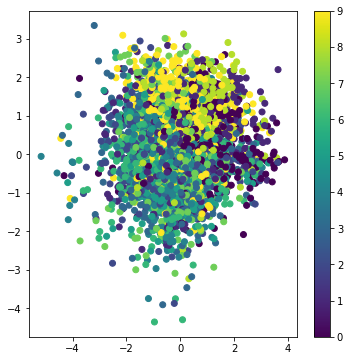

In [ ]:
if latent_dim == 3:
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1],x_test_encoded[:, 2], c=y_test)
    plt.show()

if latent_dim == 2:
    # display a 2D plot of the classes in the latent space
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
    plt.colorbar()
    plt.show()

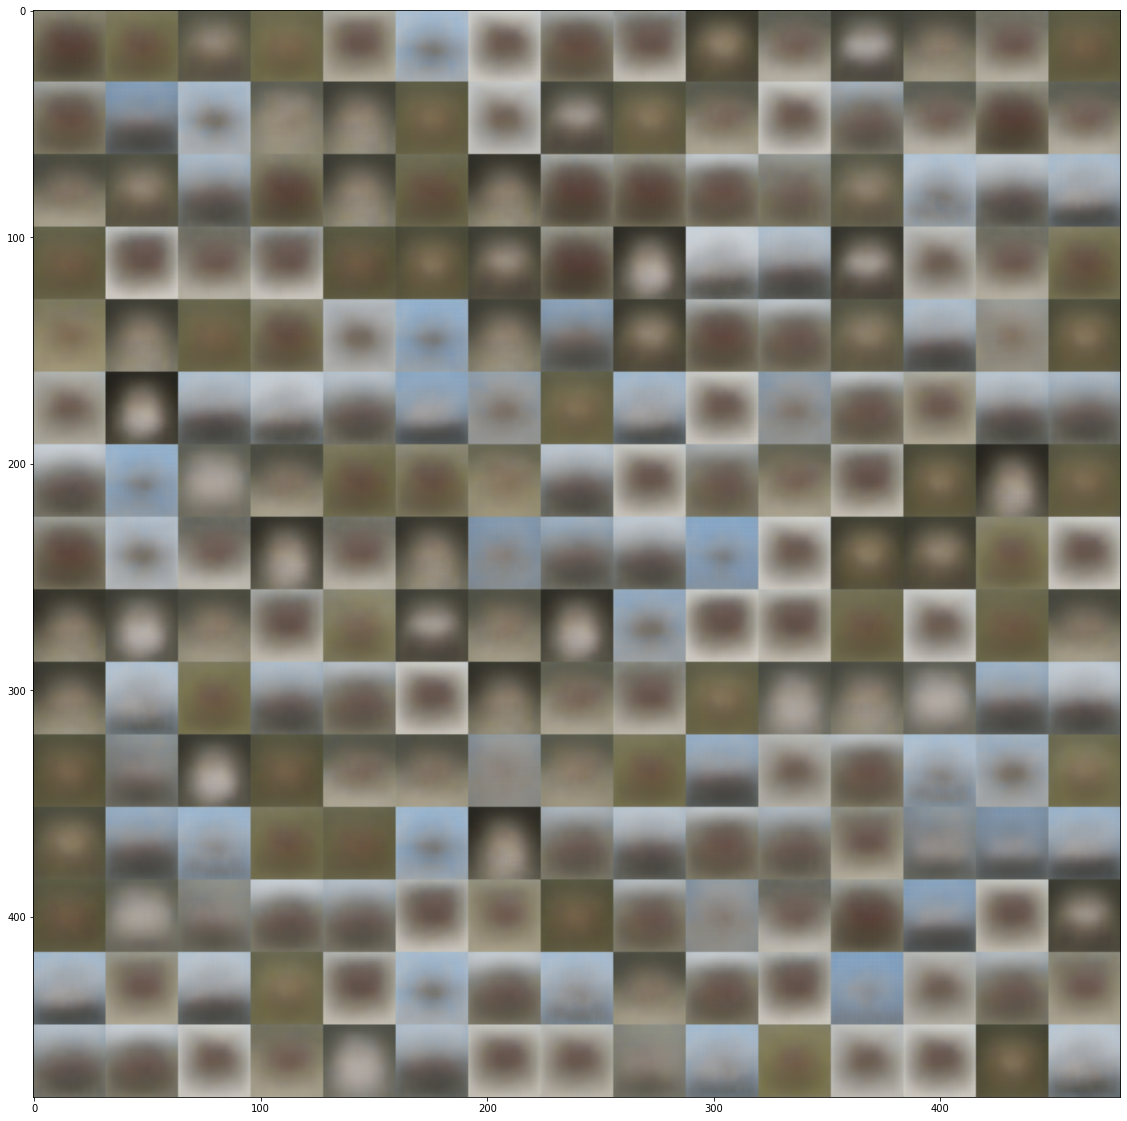

In [ ]:
from scipy.stats import norm
n = 15
img_size = 32
figure = np.zeros((img_size * n, img_size * n, img_chns))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
        x_decoded = generator.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size, img_chns)
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img

        #plt.figure(figsize=(5, 5))
        #plt.imshow(img, cmap='Greys_r')
        #plt.show()


plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()